In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os, glob, tables
from astropy.coordinates import EarthLocation, SkyCoord
from astropy import units as u
from astropy.coordinates import AltAz

vectorized_fromtimestamp = np.vectorize(datetime.fromtimestamp)

# LST Earth location
observing_location = EarthLocation.of_site("Roque de los Muchachos")

### Definition of variables

In [2]:
# The name of the source
source_name = "S240615dg"

# Arrays with the LST and MAGIC run numbers to be plotted
obs_ids_lst   = np.arange(17820, 17825 + 1)
obs_ids_magic = np.arange(5115111, 5115116 + 1)

# Root path for the DL1 LST files, works running on IT cluster
root_dl1_lst   = "/fefs/aswg/data/real/DL1/????????/v*/tailcut84/"

# Folder with the DL1 MAGIC files: dl1_MX.Run????????.h5
root_dl1_magic = "/fefs/aswg/workspace/juan.jimenez/data_magiclst/S240615dg/DL1/MAGIC/"

# Coordinate object for the source
source_coord = SkyCoord(ra=7.53*u.deg, dec=45.81*u.deg)
# source_coord = SkyCoord.from_name(source_name)

### Extracting filenames

In [3]:
fnames_dl1, tabs_dl1 = [], []
for obs_id in obs_ids_lst:
    fnames_obs_id = glob.glob(root_dl1_lst + f"dl1_LST-1.Run{obs_id:05}.h5")
    if len(fnames_obs_id) == 0:
        print(f"No files found in {root_dl1_lst} for obs id {obs_id}")
    else:
        fnames_dl1.append(fnames_obs_id[0])
        tabs_dl1.append(tables.open_file(fnames_obs_id[0]).root)
fnames_m1, fnames_m2 = [], []
for obs_id in obs_ids_magic:
    fnames_obs_id_m1 = glob.glob(root_dl1_magic + f"dl1_M1.Run{obs_id:08}.h5")
    fnames_obs_id_m2 = glob.glob(root_dl1_magic + f"dl1_M2.Run{obs_id:08}.h5")
    if len(fnames_obs_id_m1) == 0 or len(fnames_obs_id_m2) == 0:
        print(f"No files found in {root_dl1_magic} for obs id {obs_id}")
    else:
        fnames_m1.append(fnames_obs_id_m1[0])
        fnames_m2.append(fnames_obs_id_m2[0])

### Extracting information
The variable `num_skips` is the frequancy for skipping events. Using all events of one run can be heavy and long for the related calculus. Then the `num_skips` means the frequency of keeped events, i.e. `num_skips=1` means all events, `num_skips=2` one each two events and so on.

In [4]:
num_skips_magic = 10
num_skips_lst   = 50

alt_m1, az_m1, time_m1 = [], [], []
alt_m2, az_m2, time_m2 = [], [], []
for i in range(len(fnames_m1)):
    print(f"Extracting info from MAGIC Run {obs_ids_magic[i]}... {i+1}/{len(fnames_m1)}")
    tab_m1 = tables.open_file(fnames_m1[i]).root.events.parameters
    tab_m2 = tables.open_file(fnames_m2[i]).root.events.parameters
    alt_m1.append(np.rad2deg(tab_m1.col("pointing_alt")[::num_skips_magic]))
    alt_m2.append(np.rad2deg(tab_m2.col("pointing_alt")[::num_skips_magic]))
    az_m1.append(np.rad2deg(tab_m1.col("pointing_az")[::num_skips_magic]))
    az_m2.append(np.rad2deg(tab_m2.col("pointing_az")[::num_skips_magic]))
    time_m1.append(vectorized_fromtimestamp(
        tab_m1.col("time_sec")[::num_skips_magic] + tab_m1.col("time_nanosec")[::num_skips_magic] * 1e-9))
    time_m2.append(vectorized_fromtimestamp(
        tab_m2.col("time_sec")[::num_skips_magic] + tab_m2.col("time_nanosec")[::num_skips_magic] * 1e-9))
    tab_m1.close()
    tab_m2.close()
    
alt_lst, az_lst, time_lst = [], [], []
for i in range(len(tabs_dl1)):
    print(f"Extracting info from LST Run {obs_ids_lst[i]}... {i+1}/{len(obs_ids_lst)}")
    tab = tabs_dl1[i].dl1.event.telescope.parameters.LST_LSTCam
    alt_lst.append(np.rad2deg(tab.col("alt_tel")[::num_skips_lst]))
    az_lst.append(np.rad2deg(tab.col("az_tel")[::num_skips_lst]))
    time_lst.append(vectorized_fromtimestamp(tab.col("dragon_time")[::num_skips_lst]))
    tab.close()

Extracting info from MAGIC Run 5115111... 1/6
Extracting info from MAGIC Run 5115112... 2/6
Extracting info from MAGIC Run 5115113... 3/6
Extracting info from MAGIC Run 5115114... 4/6
Extracting info from MAGIC Run 5115115... 5/6
Extracting info from MAGIC Run 5115116... 6/6
Extracting info from LST Run 17820... 1/6
Extracting info from LST Run 17821... 2/6
Extracting info from LST Run 17822... 3/6
Extracting info from LST Run 17823... 4/6
Extracting info from LST Run 17824... 5/6
Extracting info from LST Run 17825... 6/6


### Computing AltAz coordinates of the source during observations

In [5]:
observing_timestamps = np.linspace(
    np.min([time_lst[0][0], time_m1[0][0], time_m2[0][0]]).timestamp(), 
    np.max([time_lst[-1][-1], time_m1[-1][-1], time_m2[-1][-1]]).timestamp(),
    100
)
observing_times = vectorized_fromtimestamp(observing_timestamps)

alt_source, az_source = [], []
for i, t in enumerate(observing_times):
    altaz = AltAz(location=observing_location, obstime=t)
    coord_altaz = source_coord.transform_to(altaz)

    _az, _alt  = coord_altaz.az, coord_altaz.alt
    alt_source.append(_alt.value)
    az_source.append(_az.value)

### Computing RaDec coordinates for the telescope pointing
Again using `num_skips` to keep less data.

In [6]:
%%time
num_skips_magic = 30
num_skips_lst   = 100

ra_m1, dec_m1, time_radec_m1 = [], [], []
ra_m2, dec_m2, time_radec_m2 = [], [], []
for i in range(len(obs_ids_magic)):
    print(f"Extracting info from MAGIC Run {obs_ids_magic[i]}... {i+1}/{len(obs_ids_magic)}")
    
    _time_m1, _time_m2 = time_m1[i][::num_skips_magic], time_m2[i][::num_skips_magic]
    _alt_m1, _alt_m2 = alt_m1[i][::num_skips_magic],  alt_m2[i][::num_skips_magic]
    _az_m1, _az_m2 = az_m1[i][::num_skips_magic],   az_m2[i][::num_skips_magic]
    
    _ra_m1, _dec_m1, _time_radec_m1 = [], [], []
    for j in range(len(_az_m1)):
        altaz = AltAz(
            alt = _alt_m1[j] * u.deg,
            az = _az_m1[j] * u.deg, 
            obstime = _time_m1[j], 
            location = observing_location
        )
        skycoord_altaz = SkyCoord(altaz)
        skycoord_icrs = skycoord_altaz.transform_to("icrs")
        _ra_m1.append(skycoord_icrs.ra.deg)
        _dec_m1.append(skycoord_icrs.dec.deg)
        _time_radec_m1.append(_time_m1[j])
    _ra_m2, _dec_m2, _time_radec_m2 = [], [], []
    x, y = [], []
    for j in range(len(_az_m2)):
        altaz = AltAz(
            alt = _alt_m2[j] * u.deg,
            az = _az_m2[j] * u.deg, 
            obstime = _time_m2[j], 
            location = observing_location
        )
        skycoord_altaz = SkyCoord(altaz)
        skycoord_icrs = skycoord_altaz.transform_to("icrs")
        _ra_m2.append(skycoord_icrs.ra.deg)
        _dec_m2.append(skycoord_icrs.dec.deg)
        _time_radec_m2.append(_time_m2[j])
        
    ra_m1.append(_ra_m1)
    ra_m2.append(_ra_m2)
    dec_m1.append(_dec_m1)
    dec_m2.append(_dec_m2)
    time_radec_m1.append(_time_radec_m1)
    time_radec_m2.append(_time_radec_m2)
    
ra_lst, dec_lst, time_radec_lst = [], [], []
for i in range(len(obs_ids_lst)):
    print(f"Extracting info from LST Run {obs_ids_lst[i]}... {i+1}/{len(obs_ids_lst)}")
    
    _time = time_lst[i][::num_skips_lst]
    _alt = alt_lst[i][::num_skips_lst]
    _az = az_lst[i][::num_skips_lst]
    
    _ra, _dec, _time_radec = [], [], []
    for j in range(len(_az)):
        altaz = AltAz(
            alt = _alt[j] * u.deg,
            az = _az[j] * u.deg, 
            obstime = _time[j], 
            location = observing_location
        )
        skycoord_altaz = SkyCoord(altaz)
        skycoord_icrs = skycoord_altaz.transform_to("icrs")
        _ra.append(skycoord_icrs.ra.deg)
        _dec.append(skycoord_icrs.dec.deg)
        _time_radec.append(_time[j])
        
    ra_lst.append(_ra)
    dec_lst.append(_dec)
    time_radec_lst.append(_time_radec)

Extracting info from MAGIC Run 5115111... 1/6
Extracting info from MAGIC Run 5115112... 2/6
Extracting info from MAGIC Run 5115113... 3/6
Extracting info from MAGIC Run 5115114... 4/6
Extracting info from MAGIC Run 5115115... 5/6
Extracting info from MAGIC Run 5115116... 6/6
Extracting info from LST Run 17820... 1/6
Extracting info from LST Run 17821... 2/6
Extracting info from LST Run 17822... 3/6
Extracting info from LST Run 17823... 4/6
Extracting info from LST Run 17824... 5/6
Extracting info from LST Run 17825... 6/6
CPU times: user 1min 52s, sys: 1.44 s, total: 1min 54s
Wall time: 1min 52s


### Computing sky separation of telescopes and the source

In [7]:
sep_lst, sep_m1, sep_m2 = [], [], []
for i in range(len(obs_ids_lst)):
    coords = SkyCoord(ra=ra_lst[i] * u.deg, dec=dec_lst[i] * u.deg)
    sep_lst.append(source_coord.separation(coords).deg)
for i in range(len(obs_ids_magic)):
    coords_m1 = SkyCoord(ra=ra_m1[i] * u.deg, dec=dec_m1[i] * u.deg)
    coords_m2 = SkyCoord(ra=ra_m2[i] * u.deg, dec=dec_m2[i] * u.deg)
    sep_m1.append(source_coord.separation(coords_m1).deg)
    sep_m2.append(source_coord.separation(coords_m2).deg)

### Plot in AltAz coordinates

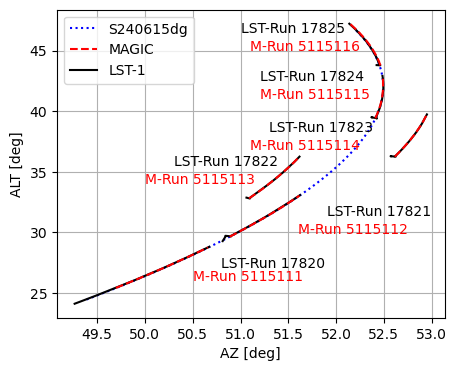

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.plot(az_source, alt_source, marker="", color="b", ls=":", label="S240615dg")
for i in range(len(az_lst)):    
    ax.plot(az_lst[i], alt_lst[i], color="k", )#label=f"LST-1 Run {runsl[i]}")
    
for i in range(len(az_m2)):    
    ax.plot(az_m2[i], alt_m2[i], color="r", ls="--", )#label=f"MAGIC Run {runsm[i]}")

    
# Text positions need to be changed manually
text_x_magic = [50.5, 51.6, 50, 51.1, 51.2, 51.1]
text_y_magic = [26, 29.9, 34, 36.8, 41, 45]
text_x_lst = [50.8, 51.9, 50.3, 51.3, 51.2, 51]
text_y_lst = [27.1, 31.4, 35.5, 38.3, 42.5, 46.5]
for i in range(len(obs_ids_magic)):
    ax.text(text_x_magic[i], text_y_magic[i], f"M-Run {obs_ids_magic[i]}", color="r")
for i in range(len(obs_ids_lst)):
    ax.text(text_x_lst[i], text_y_lst[i], f"LST-Run {obs_ids_lst[i]}", color="k")  
    
ax.plot([], [], color="r", ls="--", label="MAGIC")
ax.plot([], [], color="k", ls="-", label="LST-1")
ax.grid()
ax.legend(loc="best", frameon=True)
ax.set_xlabel("AZ [deg]")
ax.set_ylabel("ALT [deg]")
    
# ax.set_title("S240615dg")

# plt.savefig(f"plot_altaz_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

### Plot in RaDec coordinates

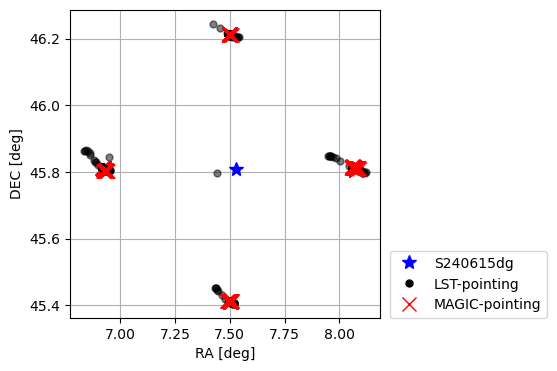

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(source_coord.ra, source_coord.dec, marker="*", ls="", ms=10, color="b", label=f"{source_name}")

for i in range(len(obs_ids_magic)):
    ax.plot(ra_lst[i], dec_lst[i], marker=".", ls="", ms=10, color="k", alpha=0.5)
    ax.plot(ra_m2[i], dec_m2[i], marker="x", ls="", ms=10, color="r", alpha=0.5)

ax.plot([], [], marker=".", ls="", ms=10, color="k", alpha=1, label="LST-pointing")
ax.plot([], [], marker="x", ls="", ms=10, color="r", alpha=1, label="MAGIC-pointing")
ax.grid()
ax.legend(loc=(1.03, 0))
ax.set_xlabel("RA [deg]")
ax.set_ylabel("DEC [deg]")

# plt.savefig(f"plot_radec_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()

### Separation between telescope pointings and source plot

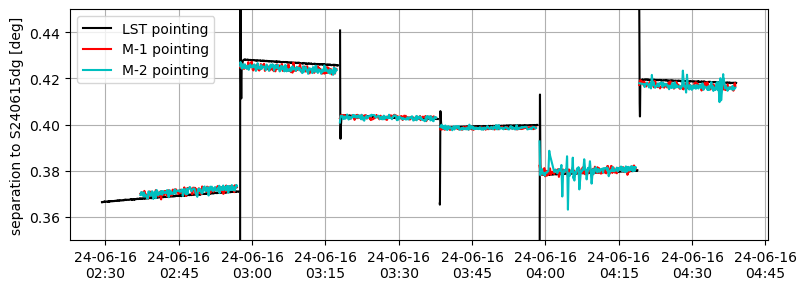

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

for i in range(len(obs_ids_lst)):
    ax.plot(time_radec_lst[i], sep_lst[i], color="k", ls="-")
for i in range(len(obs_ids_magic)):
    ax.plot(time_radec_m1[i], sep_m1[i], color="r", ls="-")
    ax.plot(time_radec_m2[i], sep_m2[i], color="c", ls="-")

ax.grid()
ax.set_ylim(0.35, 0.45)

ax.plot([], [], color="k", ls="-", label="LST pointing")
ax.plot([], [], color="r", ls="-", label="M-1 pointing")
ax.plot([], [], color="c", ls="-", label="M-2 pointing")
ax.legend()
myFmt = mdates.DateFormatter("%y-%m-%d\n%H:%M")
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel(f"separation to {source_name} [deg]")

# plt.savefig(f"plot_separation_{source_name}.png", bbox_inches="tight", dpi=300)
plt.show()